Responsibility Classification with Vowpal Wabbit
===

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../../annotation_data")

In [3]:
from responsibility import *
from vw import *

In [4]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import sklearn.model_selection
import subprocess
import scipy

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

In [6]:
candidate_sites_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites"
valid_classification_sites_filename = os.path.join(candidate_sites_working_dir, "valid_classification_sites_filtered.txt")
with open(valid_classification_sites_filename, 'r') as infile:
    valid_sites = [int(line.strip()) for line in infile.readlines() if line.strip() != ""]
len(valid_sites)

4946

In [7]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw"
assert os.path.exists(working_dir)

### Multiclass

Cost-sensitive one-against-all

https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Cost-Sensitive-One-Against-All-(csoaa)-multi-class-example

In [8]:
resp_subset = high_irr_responsibility_labels
# resp_subset should be either high_irr_responsibility_labels or responsibility_labels, probably

In [9]:
csoaa_named_labels = get_responsibility_named_labels(resp_subset=resp_subset)
csoaa_named_labels

'coordinating_support,sharing_medical_info,compliance,financial_management,giving_back,behavior_changes'

In [10]:
annotated_df = get_annotated_responsibility_df_fixed(conflict_score_cost=0.1, resp_subset=resp_subset)
len(annotated_df)

1895

In [ ]:
annotated_df.head(n=2)

In [20]:
full_df = add_sites_to_responsibility_df(annotated_df, valid_sites)
len(full_df)

100%|██████████| 4946/4946 [03:51<00:00, 21.38it/s]
../../annotation_data/responsibility.py:424: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if drop_duplicate_journals:


157389

In [21]:
np.sum(full_df.is_annotated)

1895

In [13]:
csoaa_df_filepath = os.path.join(working_dir, "full_df.pkl")

In [23]:
full_df.reset_index(drop=True, inplace=True)
full_df.to_pickle(csoaa_df_filepath)

In [14]:
full_df = pd.read_pickle(csoaa_df_filepath)

In [15]:
len(full_df)

157389

In [93]:
validation_pct = 0.2
annotated_sites = set(annotated_df.site_id)
validation_site_count = int(len(annotated_sites) * validation_pct)
print(f"Chose {validation_site_count}/{len(annotated_sites)} sites for validation.")
validation_site_ids = random.sample(annotated_sites, validation_site_count)

Chose 16/82 sites for validation.


In [94]:
vw_train_filepath, vw_test_filepath, holdout_after = \
            format_responsibility_df_as_multiclass(full_df, working_dir, 
                                                   validation_site_ids=validation_site_ids,
                                                   resp_subset=resp_subset,
                                                   include_unannotated=False)
print("Finished.")

Wrote 1891 lines (1573 train, 318 validation) to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.train'.
Finished.


In [32]:
vw_train_filepath = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.train"
vw_test_filepath = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.test"

In [24]:
!du -h {working_dir}/*csoaa* | sort -hr

346M	/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.test
30M	/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default_test.pred.raw
25M	/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.model
9.9M	/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default_test.pred
4.3M	/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.train
3.1M	/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.train.cache
496K	/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/respo

In [ ]:
!head {vw_train_filepath} -n 1

In [96]:
# Compute the index for which we will consider the remaining journals to be validation data
#validation_pct = 0.2
#holdout_after = int(len(full_df[full_df.is_annotated]) * (1 - validation_pct))
holdout_after

1573

In [97]:
%%bash -s {working_dir} {vw_train_filepath} {vw_test_filepath} {csoaa_named_labels} {holdout_after}
working_dir="${1}"
train_file="${2}"
test_file="${3}"

num_classes=13
named_labels="${4}"
holdout_after="${5}"
echo "Training on training set (holdout after ${holdout_after} lines)."

model_file=${working_dir}/responsibility_csoaa_default.model
vw -k -c -b 27 --csoaa ${num_classes} -d ${train_file} -f ${model_file} --passes 20 --holdout_after ${holdout_after} --named_labels ${named_labels} --ngram 2 --skips 1
echo

pred_train_file="${working_dir}/responsibility_csoaa_default_train.pred"
echo "Outputting raw predictions to file '${pred_train_file}.raw'."
echo
vw -t -i ${model_file} -p ${pred_train_file} -d ${train_file} -r ${pred_train_file}.raw
echo

echo "Predicting on test set."
pred_test_file=${working_dir}/responsibility_csoaa_default_test.pred
vw -t -i ${model_file} -p ${pred_test_file} -d ${test_file} -r ${pred_test_file}.raw
echo
 
echo "Finished."

Training on training set (holdout after 1573 lines).

Outputting raw predictions to file '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default_train.pred.raw'.


Predicting on test set.

Finished.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [98]:
raw_train_preds_filepath = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default_train.pred.raw"
assert os.path.exists(raw_train_preds_filepath)

In [102]:
!head -n 1 {raw_train_preds_filepath}

1:-0.233087 2:-0.256678 3:-0.0364169 4:1.83683 5:1.82155 6:1.51672 sid655867joid51be89cb6ca0046f3100249b


In [119]:
train_preds = read_raw_multiclass_responsibility_preds(raw_train_preds_filepath, resp_subset=resp_subset)
assert len(train_preds) == len(full_df[full_df.is_annotated])

In [120]:
train_df = train_preds.iloc[:holdout_after+1]
val_df = train_preds.iloc[holdout_after+1:]
len(train_df), len(val_df)

(1574, 317)

In [ ]:
raw_test_preds_filepath = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default_test.pred.raw"
assert os.path.exists(raw_test_preds_filepath)
test_df = read_raw_multiclass_responsibility_preds(raw_test_preds_filepath)
len(test_df)

#### Validation Set Analysis

We're interested in a few things:
 - What is the performance of the classifier on the validation set?
 - Where should we set the per-responsibility thresholds to maximize performance (F2 score)?

In [122]:
annotated = full_df[full_df.is_annotated]
len(annotated)

1891

In [123]:
annotated = annotated.merge(train_preds, how="left", validate="one_to_one")
# TODO Need to label the site_id and journal_oids in the validation set as such...
#annotated = annotated.merge(train_df, how="left", validate="one_to_one")
#annotated = annotated.merge(val_df, how="left", validate="one_to_one")

In [124]:
# drop the training data and leave only the validation data
# assumes that holdout_after was used to identify the validation set
annotated = annotated.iloc[holdout_after+1:]

In [125]:
# Verify that predictions for all annotations were merged into this dataframe
for col in annotated.columns:
    if col.endswith("_pred"):
        na_count = annotated[col].isna().sum()
        print(col, na_count)
        assert na_count == 0

behavior_changes_pred 0
compliance_pred 0
coordinating_support_pred 0
financial_management_pred 0
giving_back_pred 0
sharing_medical_info_pred 0


In [126]:
annotated.head()

,behavior_changes_score,clinical_decisions_score,communicating_score,compliance_score,conflict_status,continued_monitoring_score,coordinating_support_score,financial_management_score,giving_back_score,info_filtering_score,...,responsibilities,sharing_medical_info_score,site_id,symptom_management_score,behavior_changes_pred,compliance_pred,coordinating_support_pred,financial_management_pred,giving_back_pred,sharing_medical_info_pred
1574,0.0,0.0,0.0,0.9,CONFLICT,0.0,0.0,0.0,0.0,0.0,...,"[preparation, sharing_medical_info, compliance]",0.9,812280,0.0,1.060560,0.037558,1.19687,1.30844,1.13456,0.016955
1575,0.0,0.0,0.0,0.9,CONFLICT,0.0,0.0,0.0,0.0,0.0,...,"[preparation, sharing_medical_info, compliance]",0.9,812280,0.0,1.490280,0.037497,1.11208,1.84380,1.70871,-0.022450
1576,0.0,0.0,0.0,0.9,CONFLICT,0.0,0.0,0.0,0.0,0.0,...,"[symptom_management, sharing_medical_info, com...",0.9,812280,0.9,2.200040,0.139732,1.83255,2.82483,2.51440,0.143936
1577,0.0,0.0,0.0,0.9,CONFLICT,0.0,0.0,0.0,0.0,0.0,...,"[preparation, symptom_management, sharing_medi...",0.9,812280,0.9,1.571840,0.001192,1.30062,1.96373,2.16349,-0.030364
1578,0.9,0.0,0.0,0.9,CONFLICT,0.0,0.0,0.0,0.0,0.0,...,"[sharing_medical_info, compliance, behavior_ch...",0.9,812280,0.0,0.100094,0.100695,1.03037,1.16667,1.15945,0.101120


In [127]:
# build y_true matrix (n_samples,n_classes)
n_samples = len(annotated)
n_classes = len(resp_subset)
y_true = np.zeros((n_samples, n_classes))
for i in range(len(annotated)):
    row = annotated.iloc[i]
    for j, resp_label in enumerate(resp_subset):
        if row[resp_label + "_score"] > 0.5:
            y_true[i,j] = 1
y_true.shape

(317, 6)

In [128]:
# per-label positive counts
# these should all be non-zero!
list(zip(resp_subset, list(np.sum(y_true, axis=0))))

[('coordinating_support', 48.0),
 ('sharing_medical_info', 277.0),
 ('compliance', 243.0),
 ('financial_management', 7.0),
 ('giving_back', 15.0),
 ('behavior_changes', 15.0)]

In [129]:
# build y_score matrix (n_samples,n_classes)
n_samples = len(annotated)
n_classes = len(resp_subset)
y_score = np.zeros((n_samples, n_classes))
error_count = 0
for i in range(len(annotated)):
    row = annotated.iloc[i]
    for j, resp_label in enumerate(resp_subset):
        score = row[resp_label + "_pred"]
        if not np.isfinite(score):
            print(row)
            y_score[i,j] = -1.0
            error_count += 1
        else:
            y_score[i,j] = 1 - score
assert np.isfinite(y_score).all()
y_score.shape, error_count

((317, 6), 0)

In [130]:
sklearn.metrics.roc_auc_score(y_true, y_score)

0.9950678339085334

In [51]:
#y_score_norm = sklearn.preprocessing.normalize(y_score, axis=0)
y_score_norm = (y_score - y_score.min(0)) / y_score.ptp(0)

In [52]:
sklearn.metrics.roc_auc_score(y_true, y_score_norm)  # should have the same ROC score as the unnormalized version

0.9512023013371204

In [53]:
# build the y_pred matrix from y_score_norm
y_pred = np.zeros((n_samples, n_classes))
threshold = 0.5
for i in range(n_samples):
    for j in range(n_classes):
        if y_score_norm[i,j] >= threshold:
            y_pred[i,j] = 1

y_pred_fast = y_score_norm > threshold
y_pred_fast = y_pred_fast.astype(int)          
            
y_pred.shape, y_pred_fast.shape, (y_pred == y_pred_fast).all()

((377, 13), (377, 13), True)

In [128]:
print("Threshold Macro Micro Weighted Samples")
print("="*40)
scores = []
print_freq = 5
thresholds = np.linspace(0, 1, num=50)
class_f2_score_mat = np.zeros((len(thresholds), n_classes))
for i, threshold in enumerate(thresholds):
    y_pred = (y_score_norm > threshold).astype(int)
    
    class_f2_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred, 2, average=None))
    class_f2_score_mat[i,:] = class_f2_scores
    
    macro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='macro')
    micro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='micro')
    weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='weighted')
    samples_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='samples')
    scores.append((macro_f2_score, micro_f2_score, weighted_f2_score, samples_f2_score))
    if i % print_freq == 0:
        print(f"{threshold:9.2f} {macro_f2_score:5.2f} {micro_f2_score:5.2f} {weighted_f2_score:8.2f} {samples_f2_score:7.2f}")
class_f2_score_mat.shape    

Threshold Macro Micro Weighted Samples
     0.00  0.46  0.61     0.76    0.56
     0.10  0.46  0.61     0.77    0.56
     0.20  0.46  0.61     0.77    0.56
     0.31  0.46  0.61     0.78    0.57
     0.41  0.46  0.61     0.78    0.57


/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


     0.51  0.46  0.61     0.77    0.57
     0.61  0.46  0.55     0.67    0.52
     0.71  0.47  0.45     0.49    0.41
     0.82  0.52  0.40     0.39    0.34
     0.92  0.39  0.13     0.12    0.10


/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(50, 13)

Micro max threshold: 0.3061224489795918
Macro max threshold: 0.836734693877551


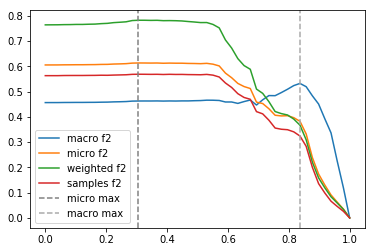

In [129]:
scores = np.array(scores)
plt.plot(thresholds, scores[:,0], label="macro f2")
plt.plot(thresholds, scores[:,1], label="micro f2")
plt.plot(thresholds, scores[:,2], label="weighted f2")
plt.plot(thresholds, scores[:,3], label="samples f2")

micro_max = thresholds[scores.argmax(0)[1]]
print("Micro max threshold:", micro_max)
plt.axvline(micro_max, color="gray", linestyle="--", label="micro max")

macro_max = thresholds[scores.argmax(0)[0]]
print("Macro max threshold:", macro_max)
plt.axvline(macro_max, color="darkgray", linestyle="--", label="macro max")

plt.legend()
plt.show()

In [130]:
# set y_pred from the threshold that maximizes f2 score using micro-averaging
y_pred = (y_score_norm >= macro_max).astype(int)
# prints the percentage of validation samples that were assigned this class based on the threshold
list(zip(responsibility_labels, list(np.sum(y_pred, axis=0) / y_pred.shape[0])))

[('communicating', 0.08222811671087533),
 ('info_filtering', 0.1246684350132626),
 ('clinical_decisions', 0.10875331564986737),
 ('preparation', 0.08222811671087533),
 ('symptom_management', 0.3395225464190981),
 ('coordinating_support', 0.11936339522546419),
 ('sharing_medical_info', 0.007957559681697613),
 ('compliance', 0.026525198938992044),
 ('managing_transitions', 0.20689655172413793),
 ('financial_management', 0.46949602122015915),
 ('continued_monitoring', 0.06631299734748011),
 ('giving_back', 0.48010610079575594),
 ('behavior_changes', 0.7029177718832891)]

In [131]:
print(sklearn.metrics.classification_report(y_true, y_pred, target_names=responsibility_labels))

                      precision    recall  f1-score   support

       communicating       0.26      1.00      0.41         8
      info_filtering       1.00      0.72      0.84        65
  clinical_decisions       0.61      0.93      0.74        27
         preparation       1.00      0.36      0.53        85
  symptom_management       1.00      0.83      0.90       155
coordinating_support       1.00      0.92      0.96        49
sharing_medical_info       1.00      0.01      0.02       326
          compliance       1.00      0.04      0.07       275
managing_transitions       0.99      0.85      0.91        91
financial_management       0.03      0.86      0.07         7
continued_monitoring       1.00      0.89      0.94        28
         giving_back       0.08      0.88      0.14        16
    behavior_changes       0.05      0.87      0.09        15

         avg / total       0.95      0.38      0.39      1147



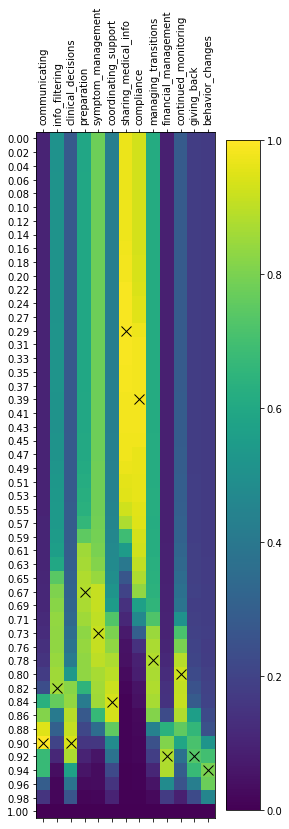

[('communicating', 0.8979591836734693),
 ('info_filtering', 0.8163265306122448),
 ('clinical_decisions', 0.8979591836734693),
 ('preparation', 0.673469387755102),
 ('symptom_management', 0.7346938775510203),
 ('coordinating_support', 0.836734693877551),
 ('sharing_medical_info', 0.2857142857142857),
 ('compliance', 0.3877551020408163),
 ('managing_transitions', 0.7755102040816326),
 ('financial_management', 0.9183673469387754),
 ('continued_monitoring', 0.7959183673469387),
 ('giving_back', 0.9183673469387754),
 ('behavior_changes', 0.9387755102040816)]

In [132]:
# visualize the per-class f2 score
plt.matshow(class_f2_score_mat)
plt.yticks(np.arange(0,50), ["%.2f" % th for th in thresholds])
plt.xticks(np.arange(0,13), responsibility_labels, rotation=90)
plt.colorbar()

for i, index in enumerate(class_f2_score_mat.argmax(axis=0)):
    plt.plot(i, index, color='black', marker='x', markersize=10)

plt.show()

# compute the threshold that maximizes F2 score for each class separately
max_per_class_thresholds = np.array([thresholds[i] for i in class_f2_score_mat.argmax(axis=0)])
list(zip(responsibility_labels, max_per_class_thresholds))

In [139]:
# rather than using a single threshold, we instead use a per-class threshold
y_pred_per_class = (y_score_norm >= max_per_class_thresholds).astype(int)
print("Proportion of Validation Samples Assigned Each Responsibility")
print("Responsibility           % Pred  % True")
print("="*60)
for resp_label, pct_assigned_positive, pct_true in zip(responsibility_labels, 
                                             list(np.sum(y_pred_per_class, axis=0) / y_pred_per_class.shape[0]),
                                             list(np.sum(y_true, axis=0) / y_pred_per_class.shape[0])):
    print(f"{resp_label:24} {pct_assigned_positive:6.2f}  {pct_true:6.2f}")
print()

macro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='macro')
micro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='micro')
weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='weighted')
samples_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='samples')
print("F2-score under different averaging conditions")
print("Macro Micro Weighted Samples")
print("="*30)
print(f"{macro_f2_score:5.2f} {micro_f2_score:5.2f} {weighted_f2_score:8.2f} {samples_f2_score:7.2f}")
print()

print(sklearn.metrics.classification_report(y_true, y_pred_per_class, target_names=responsibility_labels))

Proportion of Validation Samples Assigned Each Responsibility
Responsibility           % Pred  % True
communicating              0.02    0.02
info_filtering             0.14    0.17
clinical_decisions         0.07    0.07
preparation                0.28    0.23
symptom_management         0.46    0.41
coordinating_support       0.12    0.13
sharing_medical_info       0.89    0.86
compliance                 0.78    0.73
managing_transitions       0.28    0.24
financial_management       0.02    0.02
continued_monitoring       0.09    0.07
giving_back                0.03    0.04
behavior_changes           0.04    0.04

F2-score under different averaging conditions
Macro Micro Weighted Samples
 0.90  0.94     0.94    0.89

                      precision    recall  f1-score   support

       communicating       1.00      1.00      1.00         8
      info_filtering       1.00      0.83      0.91        65
  clinical_decisions       1.00      0.93      0.96        27
         preparation   

/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [ ]:
# save the y_score_norm and the thresholds, along with the classes
classes_filepath = os.path.join(working_dir, 'classes.npy')
np.save(classes_filepath, np.array(responsibility_labels))
y_score_filepath = os.path.join(working_dir, 'y_score.npy')
np.save(y_score_filepath, y_score_norm)
thresholds_filepath = os.path.join(working_dir, 'class_thresholds.npy')
np.save(thresholds_filepath, max_per_class_thresholds)

## Batch CSOAA Model Training

In [16]:
def train_model(annotated_df, validation_site_ids, model_label, resp_subset):
    if validation_site_ids is None:
        validation_pct = 0.2
        annotated_sites = set(annotated_df.site_id)
        validation_site_count = int(len(annotated_sites) * validation_pct)
        print(f"Choosing {validation_site_count}/{len(annotated_sites)} sites for validation.")
        validation_site_ids = random.sample(annotated_sites, validation_site_count)
    
    # Format the training file
    vw_train_filepath, vw_test_filepath, holdout_after = \
        format_responsibility_df_as_multiclass(full_df, working_dir, 
                                  validation_site_ids=validation_site_ids, 
                                  include_unannotated=False, resp_subset=resp_subset)
    print(f"Holding out after {holdout_after} training lines.")
    
    # Train the model
    vw_model_file=os.path.join(working_dir, "responsibility_csoaa_default.model")
    num_classes = len(resp_subset)
    responsibility_named_labels = get_responsibility_named_labels(resp_subset=resp_subset)
    train_file_command = f"vw -k -c -b 27 --csoaa {num_classes} -d {vw_train_filepath} -f {vw_model_file} --passes 20 --holdout_after {holdout_after} --named_labels {responsibility_named_labels} --ngram 2 --skips 1"
    proc = subprocess.run(train_file_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    print("Model trained.")
    
    # Predict on the labeled data
    train_pred_file =  os.path.join(working_dir, "responsibility_csoaa_default_train.pred")
    train_raw_pred_file = os.path.join(working_dir, "responsibility_csoaa_default_train.pred.raw")
    predict_train_command = f"vw -t -i {vw_model_file} -p {train_pred_file} -d {vw_train_filepath} -r {train_raw_pred_file}"
    proc = subprocess.run(predict_train_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    print("Predictions generated.")
    
    # Merge in the predictions with the true scores
    train_preds = read_raw_multiclass_responsibility_preds(train_raw_pred_file, resp_subset=resp_subset)
    annotated = annotated_df.merge(train_preds, how="left", validate="one_to_one")
    annotated = annotated.iloc[holdout_after+1:]
    # Verify that predictions for all annotations were merged into this dataframe
    for col in annotated.columns:
        if col.endswith("_pred"):
            na_count = annotated[col].isna().sum()
            assert na_count == 0, f"{col} NAs: {na_count}"
    annotated.reset_index(drop=True, inplace=True)
    
    # Build y_true matrix (n_samples,n_classes)
    n_samples = len(annotated)
    n_classes = len(resp_subset)
    y_train_score = annotated.loc[range(n_samples), [resp_label + "_score" for resp_label in resp_subset]].values
    y_true = (y_train_score > 0.5).astype(int)
    
    # Compute columns for which we have no or only positive validation samples
    # In this case, Recall (and thus F1 score) are undefined
    val_class_counts = np.sum(y_true, axis=0)
    true_missing_classes = val_class_counts == 0
    is_true_missing_class = np.sum(true_missing_classes) > 0
    
    # Build y_score matrix (n_samples,n_classes)
    y_score_raw = annotated.loc[range(n_samples), [resp_label + "_pred" for resp_label in resp_subset]].values
    y_score = 1 - np.clip(y_score_raw, 0, 1)
    assert np.isfinite(y_score).all(), np.sum(~np.isfinite(y_score))
    assert y_score.shape == y_true.shape
    print("Predictions merged and normalized.")
    
    # Compute f1 score at various thresholds
    thresholds = np.linspace(0, 1, num=50)
    class_f1_score_mat = np.zeros((len(thresholds), n_classes))
    for i, threshold in enumerate(thresholds):
        y_pred = (y_score > threshold).astype(int)
        class_f1_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred, 1, average=None))
        class_f1_score_mat[i,:] = class_f1_scores
        
    # compute the threshold that maximizes F1 score for each class separately
    max_per_class_thresholds = np.array([thresholds[i] for i in class_f1_score_mat.argmax(axis=0)])
    print("Decision thresholds computed.")
    
    # Compute y_pred from the chosen thresholds
    y_pred = (y_score >= max_per_class_thresholds).astype(int)
    y_pred_default = (y_score >= 0.5).astype(int)
    
    # Compute columns for which we have no positive predictions
    # In this case, Precision (and thus F2 score) are undefined
    val_pred_counts = np.sum(y_pred_default, axis=0)
    pred_missing_classes =  val_pred_counts == 0
    is_pred_missing_class = np.sum(true_missing_classes) > 0

    # Compute metrics of interest
    weighted_f1_score_thresholded = sklearn.metrics.fbeta_score(y_true, y_pred, 1, average='weighted')
    class_f1_scores_thresholded = np.array(sklearn.metrics.fbeta_score(y_true, y_pred, 1, average=None))
    weighted_f1_score = sklearn.metrics.fbeta_score(y_true, y_pred_default, 1, average='weighted')
    class_f1_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred_default, 1, average=None))
    
    weighted_precision_score = sklearn.metrics.precision_score(y_true, y_pred_default, average='weighted')
    class_precision_scores = np.array(sklearn.metrics.precision_score(y_true, y_pred_default, average=None))
    weighted_recall_score = sklearn.metrics.recall_score(y_true, y_pred_default, average='weighted')
    class_recall_scores = np.array(sklearn.metrics.recall_score(y_true, y_pred_default, average=None))
    
    if is_true_missing_class:
        print("Setting recall and F1 scores for certain classes to NaN.")
        class_recall_scores[true_missing_classes] = np.nan
        class_f1_scores[true_missing_classes] = np.nan
    if is_pred_missing_class:
        print("Setting precision and F1 scores for certain classes to NaN.")
        class_precision_scores[pred_missing_classes] = np.nan
        class_f1_scores[pred_missing_classes] = np.nan

    print(f"Finished training and evaluating model '{model_label}'.")
    
    return weighted_f1_score, weighted_precision_score, weighted_recall_score, class_f1_scores, class_precision_scores, class_recall_scores, weighted_f1_score_thresholded, class_f1_scores_thresholded

In [27]:
weighted_f1_score, weighted_precision_score, weighted_recall_score, class_f1_scores, class_precision_scores, class_recall_scores, weighted_f1_score_thresholded, class_f1_scores_thresholded = \
    train_model(annotated_df, None, "single run", high_irr_responsibility_labels)

Choosing 17/86 sites for validation.
Wrote 1895 lines (1564 train, 331 validation) to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.train'.
Holding out after 1564 training lines.
Model trained.
Predictions generated.
Predictions merged and normalized.
Decision thresholds computed.
Finished training and evaluating model 'single run'.


/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
print(f"{'Responsibility':25}  Pre   Rec   F1  F1 (Thresholded)")
print("="*60)
for i, resp_label in enumerate(resp_subset): 
    if resp_label in high_irr_responsibility_labels:
        print(f"{resp_label:25}  {class_precision_scores[i]:.2f}  {class_recall_scores[i]:.2f}  {class_f1_scores[i]:.2f}  {class_f1_scores_thresholded[i]:.2f}")
print(f"{'Mean':25}  {weighted_precision_score:.2f}  {weighted_recall_score:.2f}  {weighted_f1_score:.2f}  {weighted_f1_score_thresholded:.2f}")

Responsibility             Pre   Rec   F1  F1 (Thresholded)
coordinating_support       0.62  0.67  0.64  0.69
sharing_medical_info       0.93  0.97  0.95  0.96
compliance                 0.92  0.94  0.93  0.94
financial_management       0.31  0.44  0.36  0.44
giving_back                0.27  0.24  0.25  0.27
behavior_changes           0.35  0.38  0.36  0.36
Mean                       0.86  0.89  0.87  0.89


In [ ]:
%%capture --no-stderr --no-display kfold_stdout
# Runs n instances of k-fold cross-validation
# Expected time when n = 50 and k = 20 is ~8 hours
resp_subset = high_irr_responsibility_labels
n_results = []
n = 50
k = 20
for i in tqdm(range(n)):
    annotated_sites = np.array(list(set(annotated_df.site_id)))
    kf = sklearn.model_selection.KFold(n_splits=k)
    kfold_results = []
    index = 0
    for train_indices, val_indices in kf.split(annotated_sites):
        validation_site_ids = list(annotated_sites[val_indices])
        weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores, weighted_f2_score_thresholded, class_f2_scores_thresholded = \
            train_model(annotated_df, validation_site_ids, f"{i} {k}-fold validation model {index}", resp_subset)
        kfold_results.append((weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores, weighted_f2_score_thresholded, class_f2_scores_thresholded))
        index += 1
    n_results.append(kfold_results)
len(n_results)

 40%|████      | 20/50 [1:30:12<1:47:49, 215.65s/it]

In [ ]:
n_scores = np.zeros((n*k, 4 + 4*len(resp_subset)))
nc = len(resp_subset)
index = 0
for kfold_results in n_results:
    for tup in kfold_results:
        weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores, weighted_f2_score_thresholded, class_f2_scores_thresholded = tup
        n_scores[index, 0] = weighted_precision_score
        n_scores[index, 1] = weighted_recall_score
        n_scores[index, 2] = weighted_f2_score
        n_scores[index, 3] = weighted_f2_score_thresholded
        n_scores[index, 4:4+nc] = class_precision_scores
        n_scores[index, 4+nc:4+nc+nc] = class_recall_scores
        n_scores[index, 4+nc+nc:4+nc+nc+nc] = class_f2_scores
        n_scores[index, 4+nc+nc+nc:4+nc+nc+nc+nc] = class_f2_scores_thresholded
        index += 1
n_scores_filepath = os.path.join(working_dir, "n_scores_postfix.npy")
np.save(n_scores_filepath, n_scores)
print("Saved scores.")

In [26]:
#n_scores_filepath = os.path.join(working_dir, "n_scores_fulllabels.npy")
n_scores_filepath = os.path.join(working_dir, "n_scores_postfix.npy")
n_scores = np.load(n_scores_filepath)
resp_subset = high_irr_responsibility_labels
nc = len(resp_subset)
n_scores.shape, n, k, nc

((1000, 28), 50, 20, 6)

#### T-test comparing mean performance in "all labels" vs "high IRR labels" condition

In [208]:
n_scores_filepath = os.path.join(working_dir, "n_scores_highirrlabels.npy")
n_scores = np.load(n_scores_filepath)
resp_subset = high_irr_responsibility_labels
nc = len(resp_subset)
n_scores.shape, n, k, nc

highirr_cv_mean_scores = np.zeros((n, 4 + 4*len(resp_subset)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    highirr_cv_mean_scores[j,:] = np.nanmean(kfold_scores, axis=0)
highirr_cv_mean_scores.shape

(50, 28)

In [209]:
n_scores_filepath = os.path.join(working_dir, "n_scores_fulllabels.npy")
n_scores = np.load(n_scores_filepath)
resp_subset = responsibility_labels
nc = len(resp_subset)
n_scores.shape, n, k, nc

full_cv_mean_scores = np.zeros((n, 4 + 4*len(resp_subset)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    full_cv_mean_scores[j,:] = np.nanmean(kfold_scores, axis=0)
full_cv_mean_scores.shape

(50, 56)

In [217]:
full_f2_scores = full_cv_mean_scores[:, 2]
highirr_f2_scores = highirr_cv_mean_scores[:, 2]
np.mean(full_f2_scores), np.mean(highirr_f2_scores), np.abs(np.mean(full_f2_scores) - np.mean(highirr_f2_scores))

(0.879507202047694, 0.9360758157156711, 0.05656861366797716)

In [215]:
scipy.stats.ttest_ind(full_f2_scores, highirr_f2_scores, equal_var=False)

Ttest_indResult(statistic=-32.66151911316926, pvalue=1.142383105570018e-48)

#### End of t-test aside

In [27]:
# Compute the precision, recall, and F2 score as will be reported in the paper

# cv_mean_scores is the same as n_scores but each of the CV runs is meaned to a single row
# this isn't necessary if we just end up taking the column-wise average, since all groups are the same size.
# it could be necessary in the future if we drop some class scores that aren't valid...
cv_mean_scores = np.zeros((n, 4 + 4*len(resp_subset)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    cv_mean_scores[j,:] = np.nanmean(kfold_scores, axis=0)

print(f"{'Responsibility':25}  Pre   Rec   F1    F1 (Thresholded)")
print("="*60)
for i, resp_label in enumerate(resp_subset): 
    if resp_label in high_irr_responsibility_labels:
        class_precision = np.mean(cv_mean_scores[:,4+i])
        class_recall = np.mean(cv_mean_scores[:,4+nc+i])
        class_f2 = np.mean(cv_mean_scores[:,4+nc+nc+i])
        class_f2_thresholded = np.mean(cv_mean_scores[:,4+nc+nc+nc+i])
        print(f"{resp_label:25}  {class_precision:.2f}  {class_recall:.2f}  {class_f2:.2f}  {class_f2_thresholded:.2f}")
print(f"{'Mean':25}  {np.mean(cv_mean_scores[:,0]):.2f}  {np.mean(cv_mean_scores[:,1]):.2f}  {np.mean(cv_mean_scores[:,2]):.2f}  {np.mean(cv_mean_scores[:,3]):.2f}")

Responsibility             Pre   Rec   F1    F1 (Thresholded)
coordinating_support       0.75  0.83  0.80  0.87
sharing_medical_info       0.93  0.98  0.95  0.97
compliance                 0.90  0.97  0.93  0.95
financial_management       0.47  0.92  0.58  0.83
giving_back                0.19  0.87  0.68  0.22
behavior_changes           0.32  0.41  0.34  0.43
Mean                       0.89  0.96  0.92  0.95


In [28]:
# same as above (in fact depends on it), but generates Latex code for the table
print(f"{'Resp':4}  Pre     Rec    F1")
print("="*60)
for i, resp_label in enumerate(resp_subset): 
    if resp_label in high_irr_responsibility_labels:
        resp_code = responsibility_label_to_code_map[resp_label]
        class_precision = np.mean(cv_mean_scores[:,4+i])
        class_recall = np.mean(cv_mean_scores[:,4+nc+i])
        class_f2 = np.mean(cv_mean_scores[:,4+nc+nc+i])
        class_f2_thresholded = np.mean(cv_mean_scores[:,4+nc+nc+nc+i])
        print(f"{resp_code:4} & {class_precision:.2f} & {class_recall:.2f} & {class_f2:.2f} \\\\")
print(f"{'Mean':4} & {np.mean(cv_mean_scores[:,0]):.2f} & {np.mean(cv_mean_scores[:,1]):.2f} & {np.mean(cv_mean_scores[:,2]):.2f} \\\\")

Resp  Pre     Rec    F1
CS   & 0.75 & 0.83 & 0.80 \\
SM   & 0.93 & 0.98 & 0.95 \\
CP   & 0.90 & 0.97 & 0.93 \\
FM   & 0.47 & 0.92 & 0.58 \\
GB   & 0.19 & 0.87 & 0.68 \\
BC   & 0.32 & 0.41 & 0.34 \\
Mean & 0.89 & 0.96 & 0.92 \\


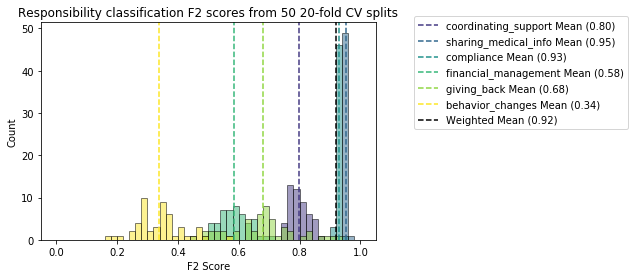

In [29]:
f2_scores_list = []
colors = []
labels = []
render_subset = high_irr_responsibility_labels
for i, resp_label in enumerate(resp_subset):
    if resp_label not in render_subset:
        continue
    f2_scores = []
    for j in range(n):
        kfold_scores = n_scores[j*k:j*k+k, 4+nc+nc+i]
        f2_scores.append(np.nanmean(kfold_scores))
    f2_scores_list.append(f2_scores)
    colors.append(plt.get_cmap('viridis')(len(f2_scores_list)*(1/len(render_subset))))
    labels.append(f'{resp_label} Mean ({np.mean(f2_scores):0.2f})')
for i in range(len(render_subset)):
    plt.hist(f2_scores_list[i], bins=50, alpha=0.5, color=colors[i], range=(0, 1), edgecolor='black')
for i in range(len(render_subset)):
    plt.axvline(np.mean(f2_scores_list[i]), linestyle='--', color=colors[i], label=labels[i])
weighted_global_mean = np.mean(n_scores[:,2])
plt.axvline(weighted_global_mean, linestyle='--', color='black', label=f'Weighted Mean ({weighted_global_mean:.2f})')
plt.title(f"Responsibility classification F2 scores from {n} {k}-fold CV splits")
plt.xlabel("F2 Score")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.1, 1.05))
phase_figure_filepath = os.path.join(working_dir, f"responsibility_cv_results_{k}fold_{n}.pdf")
plt.savefig(phase_figure_filepath, dpi=300)
plt.show()

## Generate test predictions

In [29]:
resp_subset = high_irr_responsibility_labels

#validation_pct = 0.2
#annotated_sites = set(annotated_df.site_id)
#validation_site_count = int(len(annotated_sites) * validation_pct)
#print(f"Choosing {validation_site_count}/{len(annotated_sites)} sites for validation.")
#validation_site_ids = random.sample(annotated_sites, validation_site_count)
validation_site_ids = []
    
# Format the training file
vw_train_filepath, vw_test_filepath, holdout_after = \
    format_responsibility_df_as_multiclass(full_df, working_dir, 
                              validation_site_ids=validation_site_ids, 
                              include_unannotated=True, resp_subset=resp_subset)
print(f"Holding out after {holdout_after} training lines.")

# Train the model
vw_model_file=os.path.join(working_dir, "responsibility_csoaa_full.model")
num_classes = len(resp_subset)
responsibility_named_labels = get_responsibility_named_labels(resp_subset=resp_subset)
train_file_command = f"vw -k -c -b 27 --csoaa {num_classes} -d {vw_train_filepath} -f {vw_model_file} --passes 20 --holdout_after {holdout_after} --named_labels {responsibility_named_labels} --ngram 2 --skips 1"
proc = subprocess.run(train_file_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
print("Model trained.")

# Predict on the labeled data
train_pred_file =  os.path.join(working_dir, "responsibility_csoaa_full_train.pred")
train_raw_pred_file = os.path.join(working_dir, "responsibility_csoaa_full_train.pred.raw")
predict_train_command = f"vw -t -i {vw_model_file} -p {train_pred_file} -d {vw_train_filepath} -r {train_raw_pred_file}"
proc = subprocess.run(predict_train_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
print("Training and validation predictions generated.")

# Predict on the unlabeled data
test_pred_file =  os.path.join(working_dir, "responsibility_csoaa_full_test.pred")
test_raw_pred_file = os.path.join(working_dir, "responsibility_csoaa_full_test.pred.raw")
predict_test_command = f"vw -t -i {vw_model_file} -p {test_pred_file} -d {vw_test_filepath} -r {test_raw_pred_file}"
proc = subprocess.run(predict_test_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
print("Test predictions generated.")

Wrote 1895 lines (1895 train, 0 validation) to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.train'.
Wrote 155494 lines to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_csoaa_default.test.'
Holding out after 1895 training lines.
Model trained.
Training and validation predictions generated.
Test predictions generated.


In [30]:
train_pred_file =  os.path.join(working_dir, "responsibility_csoaa_full_train.pred")
train_raw_pred_file = os.path.join(working_dir, "responsibility_csoaa_full_train.pred.raw")
test_pred_file =  os.path.join(working_dir, "responsibility_csoaa_full_test.pred")
test_raw_pred_file = os.path.join(working_dir, "responsibility_csoaa_full_test.pred.raw")

In [31]:
# Read the raw preds
train_preds = read_raw_multiclass_responsibility_preds(train_raw_pred_file, resp_subset=resp_subset)
test_preds = read_raw_multiclass_responsibility_preds(test_raw_pred_file, resp_subset=resp_subset)
assert np.sum(train_preds.duplicated(subset=['site_id', 'journal_oid'])) == 0
assert np.sum(test_preds.duplicated(subset=['site_id', 'journal_oid'])) == 0
all_preds = pd.concat([train_preds, test_preds])
all_preds.drop_duplicates(subset=['site_id', 'journal_oid'], keep='first', inplace=True)
assert np.sum(all_preds.duplicated(subset=['site_id', 'journal_oid'])) == 0
assert len(all_preds) == len(full_df)

In [32]:
# Merge in the predictions with the true scores
merged = full_df.merge(all_preds, how="left", validate="one_to_one")
merged.reset_index(drop=True, inplace=True)
assert len(merged) == len(full_df)
print("Predictions merged.")

# Verify that predictions for all journals were merged into this dataframe
for col in merged.columns:
    if col.endswith("_pred"):
        na_count = merged[col].isna().sum()
        assert na_count == 0, f"{col} NAs: {na_count}"

# Build y_score matrix (n_samples,n_classes)
n_samples = len(merged)
n_classes = len(resp_subset)
y_score_raw = merged.loc[range(n_samples), [resp_label + "_pred" for resp_label in resp_subset]].values
y_score = 1 - np.clip(y_score_raw, 0, 1)
assert np.isfinite(y_score).all()
print("Predictions merged and normalized.")
y_score.shape

Predictions merged.
Predictions merged and normalized.


(157389, 6)

In [ ]:
#TODO Could do some form of thresholding here

In [33]:
y_pred = (y_score >= 0.5).astype(int)
assert y_pred.shape == y_score.shape

In [34]:
# assign the predictions as new columns
for i, resp_label in enumerate(resp_subset):
    merged[resp_label + "_pred_label"] = y_pred[:, i]

In [35]:
# assign the true labels as new columns
for i, resp_label in enumerate(resp_subset):
    merged[resp_label + "_label"] = (merged[resp_label + "_score"] > 0.5).astype(int)

In [36]:
# To sanity-check the assignment process, we can check to make sure the accuracies on the labeled data are high
# If any of these are less than 0.7, that indicates a problem
annotated = merged[merged.is_annotated]
print(f"{'Responsibility':25}  {'Accuracy':>10}")
print("="*50)
for resp_label in resp_subset:
    acc = np.sum(annotated[resp_label + "_label"] == annotated[resp_label + "_pred_label"]) / len(annotated)
    print(f"{resp_label:25}  {acc:10.2f}")

Responsibility               Accuracy
coordinating_support             0.97
sharing_medical_info             0.99
compliance                       0.99
financial_management             0.97
giving_back                      0.97
behavior_changes                 0.97


In [37]:
# now we check that the proportion of predicted responsibilities approximately resembles the annotated proportions
annotated = merged[merged.is_annotated]
print(f"{'Responsibility':25}  {'% True':6}  {'% Pred':6}")
print("="*50)
for resp_label in resp_subset:
    true_proportion = np.sum(annotated[resp_label + "_label"]) / len(annotated)
    proportion_predicted = np.sum(merged[resp_label + "_pred_label"]) / len(merged)
    print(f"{resp_label:25}  {true_proportion:6.2f}  {proportion_predicted:6.2f}")

Responsibility             % True  % Pred
coordinating_support         0.15    0.17
sharing_medical_info         0.86    0.91
compliance                   0.77    0.85
financial_management         0.03    0.03
giving_back                  0.04    0.06
behavior_changes             0.04    0.06


In [38]:
# Just because it's a useful feature for further analysis, we save the journal text length
merged['journal_text_length'] = merged['journal_text'].apply(lambda text: len(text))

In [39]:
to_save = merged.drop(columns='journal_text')
print("Saving these columns:", to_save.columns.tolist())
all_predictions_filepath = os.path.join(working_dir, "vw_all_preds.pkl")
to_save.to_pickle(all_predictions_filepath)
print("Finished.")

Saving these columns: ['behavior_changes_score', 'compliance_score', 'conflict_status', 'coordinating_support_score', 'financial_management_score', 'giving_back_score', 'index', 'is_annotated', 'journal_oid', 'responsibilities', 'sharing_medical_info_score', 'site_id', 'behavior_changes_pred', 'compliance_pred', 'coordinating_support_pred', 'financial_management_pred', 'giving_back_pred', 'sharing_medical_info_pred', 'coordinating_support_pred_label', 'sharing_medical_info_pred_label', 'compliance_pred_label', 'financial_management_pred_label', 'giving_back_pred_label', 'behavior_changes_pred_label', 'coordinating_support_label', 'sharing_medical_info_label', 'compliance_label', 'financial_management_label', 'giving_back_label', 'behavior_changes_label', 'journal_text_length']
Finished.


#### Further analysis of model predictions

Much of this may be in the `responsibility-correlations.ipynb` notebook.

### Binary

Binary classification of each responsibility separately

https://github.com/hal3/vwnlp/blob/master/GettingTheMost.ipynb

In [136]:
# load the full_df from the csoaa pickle file
csoaa_df_filepath = os.path.join(working_dir, "full_df.pkl")
full_df = pd.read_pickle(csoaa_df_filepath)
len(full_df)

157389

In [202]:
vw_train_filepaths, vw_test_filepath = format_responsibility_df_as_binary(full_df, working_dir, 
                                                                          include_unannotated=False, 
                                                                          weight_unbalanced_classes=True)

Responsibility communicating will weight positive samples with weight 46.
Responsibility info_filtering will weight positive samples with weight 7.
Responsibility clinical_decisions will weight positive samples with weight 16.
Responsibility preparation will weight positive samples with weight 3.
Responsibility symptom_management will weight positive samples with weight 2.
Responsibility coordinating_support will weight positive samples with weight 5.
Responsibility sharing_medical_info will weight negative samples with weight 6.
Responsibility compliance will weight negative samples with weight 3.
Responsibility managing_transitions will weight positive samples with weight 3.
Responsibility financial_management will weight positive samples with weight 33.
Responsibility continued_monitoring will weight positive samples with weight 11.
Responsibility giving_back will weight positive samples with weight 22.
Responsibility behavior_changes will weight positive samples with weight 23.
Wro

In [144]:
#!head -n 1 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_continued_monitoring_default.train

In [145]:
#!head -n 1 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_compliance_default.train

In [203]:
# Compute the index for which we will consider the remaining journals to be validation data
validation_pct = 0.2
holdout_after = int(len(full_df[full_df.is_annotated]) * (1 - validation_pct))
holdout_after

1510

In [204]:
vw_train_filepaths_str = ",".join(vw_train_filepaths)
vw_train_filepaths_str

'/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_communicating_default.train,/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_info_filtering_default.train,/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_clinical_decisions_default.train,/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_preparation_default.train,/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_symptom_management_default.train,/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_coordinating_support_default.train,/home/srivbane/shared/caringbridge/data/projects/qual

In [205]:
vw_binary_responsibilities = csoaa_named_labels
vw_binary_responsibilities

'communicating,info_filtering,clinical_decisions,preparation,symptom_management,coordinating_support,sharing_medical_info,compliance,managing_transitions,financial_management,continued_monitoring,giving_back,behavior_changes'

In [206]:
%%bash -s {working_dir} {vw_binary_responsibilities} {vw_test_filepath} {holdout_after}
working_dir="${1}"
vw_binary_responsibilities="${2}"
test_file="${3}"

holdout_after="${4}"

for i in $(echo ${vw_binary_responsibilities} | sed "s/,/ /g")
do
    echo "Responsibility: ${i}" ;
    train_file="/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_${i}_default.train" ;
    model_file="${working_dir}/responsibility_binary_${i}_default.model" ;
    echo "Training from file '${train_file}.raw' to model '${model_file}'." ;
    vw -k -c -b 27 --binary --loss_function logistic --l2 0.00001 -d ${train_file} -f ${model_file} --passes 10 --holdout_after ${holdout_after} --ngram 2 --skips 1 ;
    #vw -k -c -b 27 --binary --loss_function hinge -d ${train_file} -f ${model_file} --passes 20 --holdout_after ${holdout_after} --ngram 2 --skips 1 ;
    echo ;

    pred_train_file="${working_dir}/responsibility_binary_${i}_default_train.pred" ;
    echo "Outputting raw predictions to file '${pred_train_file}.raw'." ;
    echo ;
    vw -t -i ${model_file} -p ${pred_train_file} -d ${train_file} -r ${pred_train_file}.raw ;
    echo ;
    
    #echo "Predicting on test set." ;
    #pred_test_file="${working_dir}/responsibility_binary_${i}_default_test.pred" ;
    #vw -t -i ${model_file} -p ${pred_test_file} -d ${test_file} -r ${pred_test_file}.raw ;
    #echo ;
done
 
echo "Finished."

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Generating 2-grams for all namespaces.
Generating 1-skips for all namespaces.
using l2 regularization = 1e-05
final_regressor = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_communicating_default.model
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_communicating_default.train.cache
Reading datafile = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsib

In [207]:
!head -n 5 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_compliance_default_train.pred

3.597436 sid382634joid51be46bf6ca004dd5900277e
-5.307301 sid1031202joid55a7263a8b5cd3791b2323a9
1.950661 sid131547joid51be1a916ca0047f49009b36
5.285608 sid230820joid51be32306ca0048416003f2e
4.357742 sid264906joid51be39c66ca0046a2e003ca8


In [140]:
raw_pred_template = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw/responsibility_binary_%s_default_train.pred"
binary_pred_dfs = []
for resp_label in responsibility_labels:
    raw_pred_filepath = raw_pred_template % resp_label
    resp_preds = read_raw_binary_responsibility_preds(raw_pred_filepath)
    # for hinge predictions:
    #resp_preds['pred'] = (resp_preds['raw_pred'] > 0).astype(int)
    # for logistic predictions:
    resp_preds['pred'] = 1/(1+np.exp(resp_preds['raw_pred']))
    binary_pred_dfs.append(resp_preds)
len(binary_pred_dfs)

13

In [141]:
# confirm that the model contains probabilities in the range 0-1
# (the outputted value should be very close to 1)
np.ptp(binary_pred_dfs[0]['pred'])

0.9999999999999922

In [142]:
# identify the site_id/journal_oid pairs that are in the validation set
annotated_df = full_df[full_df.is_annotated]
# note: this approach assumes that all responsibility dfs have the same subset of samples for validation
sample_val_df = binary_pred_dfs[0].iloc[holdout_after+1:]

# to make the annotated entries align perfectly with the predictions, we sort all of them by site_id/journal_oid
#.sort_values(by=["site_id", "journal_oid"])
#for binary_pred_df in binary_pred_dfs:
#    binary_pred_df.sort_values(by=["site_id", "journal_oid"], inplace=True)
val_df = pd.merge(annotated_df, sample_val_df, on=["site_id", "journal_oid"], how='inner')
val_df = val_df.drop(columns=['raw_pred', 'pred'])

# to make the annotated entries align perfectly with the predictions, we sort all of them by site_id/journal_oid
val_df = val_df.sort_values(by=["site_id", "journal_oid"])
binary_val_dfs = []
for binary_pred_df in binary_pred_dfs:
    binary_val_df = binary_pred_df.iloc[holdout_after+1:]
    binary_val_df = binary_val_df.sort_values(by=["site_id", "journal_oid"])
    binary_val_dfs.append(binary_val_df)

In [143]:
# build y_true matrix (n_samples,n_classes)
n_samples = len(val_df)
n_classes = len(responsibility_labels)
y_true = np.zeros((n_samples, n_classes))
for i in range(len(val_df)):
    row = val_df.iloc[i]
    for j, resp_label in enumerate(responsibility_labels):
        if row[resp_label + "_score"] > 0.5:
            y_true[i,j] = 1
y_true.shape

(377, 13)

In [144]:
# build y_score matrix (n_samples,n_classes)
n_samples = len(val_df)
n_classes = len(responsibility_labels)
y_score = np.zeros((n_samples, n_classes))
error_count = 0
for i in range(n_samples):
    for j, resp_label in enumerate(responsibility_labels):
        score = binary_val_dfs[j].iloc[i]["pred"]
        if not np.isfinite(score):
            print(i, j, score)
            y_score[i,j] = -1.0
            error_count += 1
        else:
            y_score[i,j] = 1 - score
assert np.isfinite(y_score).all()
y_score.shape, error_count

((377, 13), 0)

In [145]:
sklearn.metrics.roc_auc_score(y_true, y_score)

0.5722931844432928

In [146]:
print("Threshold Macro Micro Weighted")
print("="*40)
scores = []
print_freq = 5
thresholds = np.linspace(0, 1, num=50)

class_f2_score_mat = np.zeros((len(thresholds), n_classes))
for i, threshold in enumerate(thresholds):
    y_pred = (y_score > threshold).astype(int)
    class_f2_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred, 2, average=None))
    class_f2_score_mat[i,:] = class_f2_scores
    macro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='macro')
    micro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='micro')
    weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='weighted')
    scores.append((macro_f2_score, micro_f2_score, weighted_f2_score))
    if i % print_freq == 0:
        print(f"{threshold:9.2f} {macro_f2_score:5.2f} {micro_f2_score:5.2f} {weighted_f2_score:8.2f}")

Threshold Macro Micro Weighted
     0.00  0.45  0.60     0.76
     0.10  0.40  0.68     0.73
     0.20  0.36  0.69     0.70
     0.31  0.31  0.69     0.67
     0.41  0.28  0.68     0.64
     0.51  0.25  0.66     0.62
     0.61  0.20  0.60     0.56
     0.71  0.16  0.51     0.48
     0.82  0.12  0.43     0.41
     0.92  0.09  0.31     0.29


/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Micro max threshold: 0.14285714285714285


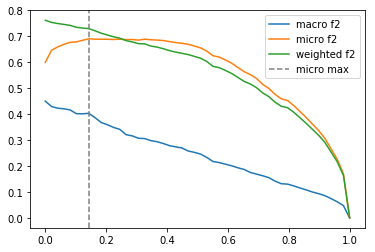

In [147]:
scores = np.array(scores)
plt.plot(thresholds, scores[:,0], label="macro f2")
plt.plot(thresholds, scores[:,1], label="micro f2")
plt.plot(thresholds, scores[:,2], label="weighted f2")

micro_max = thresholds[scores.argmax(0)[1]]
print("Micro max threshold:", micro_max)
plt.axvline(micro_max, color="gray", linestyle="--", label="micro max")

plt.legend()
plt.show()

In [148]:
y_pred = (y_score > micro_max).astype(int)

In [149]:
print(sklearn.metrics.classification_report(y_true, y_pred, target_names=responsibility_labels))

                      precision    recall  f1-score   support

       communicating       0.05      0.09      0.06        11
      info_filtering       0.21      0.76      0.33        51
  clinical_decisions       0.09      0.42      0.15        19
         preparation       0.25      0.66      0.36        90
  symptom_management       0.34      0.98      0.51       122
coordinating_support       0.15      0.57      0.24        51
sharing_medical_info       0.88      1.00      0.93       330
          compliance       0.79      1.00      0.88       297
managing_transitions       0.20      0.40      0.27        82
financial_management       0.03      0.09      0.04        11
continued_monitoring       0.09      0.26      0.14        35
         giving_back       0.04      0.23      0.07        13
    behavior_changes       0.10      0.29      0.15        17

         avg / total       0.56      0.83      0.64      1129



#### Setting a per-class decision boundary

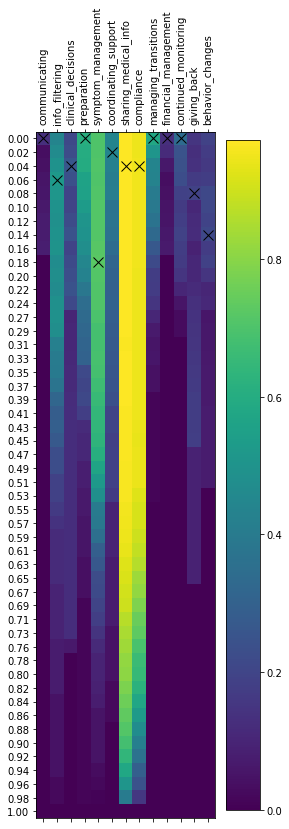

[('communicating', 0.0),
 ('info_filtering', 0.061224489795918366),
 ('clinical_decisions', 0.04081632653061224),
 ('preparation', 0.0),
 ('symptom_management', 0.18367346938775508),
 ('coordinating_support', 0.02040816326530612),
 ('sharing_medical_info', 0.04081632653061224),
 ('compliance', 0.04081632653061224),
 ('managing_transitions', 0.0),
 ('financial_management', 0.0),
 ('continued_monitoring', 0.0),
 ('giving_back', 0.08163265306122448),
 ('behavior_changes', 0.14285714285714285)]

In [150]:
# visualize the per-class f2 score
plt.matshow(class_f2_score_mat)
plt.yticks(np.arange(0,50), ["%.2f" % th for th in thresholds])
plt.xticks(np.arange(0,13), responsibility_labels, rotation=90)
plt.colorbar()

for i, index in enumerate(class_f2_score_mat.argmax(axis=0)):
    plt.plot(i, index, color='black', marker='x', markersize=10)

plt.show()

# compute the threshold that maximizes F2 score for each class separately
max_per_class_thresholds = np.array([thresholds[i] for i in class_f2_score_mat.argmax(axis=0)])
list(zip(responsibility_labels, max_per_class_thresholds))

In [151]:
# rather than using a single threshold, we instead use a per-class threshold
y_pred_per_class = (y_score_norm >= max_per_class_thresholds).astype(int)
print("Proportion of Validation Samples Assigned Each Responsibility")
print("Responsibility           % Pred  % True")
print("="*60)
for resp_label, pct_assigned_positive, pct_true in zip(responsibility_labels, 
                                             list(np.sum(y_pred_per_class, axis=0) / y_pred_per_class.shape[0]),
                                             list(np.sum(y_true, axis=0) / y_pred_per_class.shape[0])):
    print(f"{resp_label:24} {pct_assigned_positive:6.2f}  {pct_true:6.2f}")
print()

macro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='macro')
micro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='micro')
weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='weighted')
samples_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='samples')
print("F2-score under different averaging conditions")
print("Macro Micro Weighted Samples")
print("="*30)
print(f"{macro_f2_score:5.2f} {micro_f2_score:5.2f} {weighted_f2_score:8.2f} {samples_f2_score:7.2f}")
print()

print(sklearn.metrics.classification_report(y_true, y_pred_per_class, target_names=responsibility_labels))

Proportion of Validation Samples Assigned Each Responsibility
Responsibility           % Pred  % True
communicating              1.00    0.03
info_filtering             0.99    0.14
clinical_decisions         1.00    0.05
preparation                1.00    0.24
symptom_management         1.00    0.32
coordinating_support       1.00    0.14
sharing_medical_info       0.99    0.88
compliance                 1.00    0.79
managing_transitions       1.00    0.22
financial_management       1.00    0.03
continued_monitoring       1.00    0.09
giving_back                1.00    0.03
behavior_changes           1.00    0.05

F2-score under different averaging conditions
Macro Micro Weighted Samples
 0.45  0.60     0.76    0.56

                      precision    recall  f1-score   support

       communicating       0.03      1.00      0.06        11
      info_filtering       0.14      1.00      0.24        51
  clinical_decisions       0.05      1.00      0.10        19
         preparation   

/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
